# AuraFin: Cost-Sensitive Credit Risk Engine
##  Exploratory Data Analysis (EDA) & Strategic Preprocessing

###  Objectives
In this notebook, we perform deep **Exploratory Data Analysis** to understand the statistical properties of our features and apply **Preprocessing** to handle missing data.

###  Mathematical & Business Logic
1.  **Distributional Analysis (Income):** Financial data (Income) typically follows a **Log-Normal Distribution** ($Y \sim \ln(\mathcal{N}(\mu, \sigma^2))$). This means the **Mean** ($\mu$) is pulled by outliers (billionaires), making it an unreliable representation of the "typical" borrower. We will verify this skew to justify using **Median Imputation**.
2.  **Feature-Target Correlation:** We need to verify which features actually separate Defaulters ($Y=1$) from Payers ($Y=0$). We expect **LTV (Loan-to-Value)** to show a strong separation, validating the "Skin in the Game" hypothesis.
3.  **Missingness Informationality:** For categorical variables, "Missing" often isn't random—it's a signal. Instead of dropping these, we will treat "Unknown" as a distinct category.

In [16]:
# ---------------------------------------------------------
# Imports & Load Data
# ---------------------------------------------------------
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

# Set Professional Style
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

# Load the "Forensic Cleaned" data from Notebook 01
input_path = '../data/processed/01_cleaned_data.csv'

if os.path.exists(input_path):
    df = pd.read_csv(input_path)
    print(f" Loaded Data. Shape: {df.shape}")
else:
    print(" Error: 01_cleaned_data.csv not found. Please run Notebook 01 first.")

df.head()

 Loaded Data. Shape: (47728, 31)


,ID,year,loan_limit,Gender,approv_in_adv,loan_type,loan_purpose,Credit_Worthiness,open_credit,business_or_commercial,...,credit_type,Credit_Score,co-applicant_credit_type,age,submission_of_application,LTV,Region,Security_Type,Status,dtir1
0,24891,2019,cf,Male,nopre,type2,p1,l1,nopc,b/c,...,EQUI,552,EXP,55-64,to_inst,NaN,North,direct,1,NaN
1,24892,2019,cf,Male,pre,type1,p1,l1,nopc,nob/c,...,EXP,834,CIB,35-44,to_inst,80.019685,south,direct,0,46.0
2,24893,2019,cf,Male,nopre,type1,p4,l1,nopc,nob/c,...,EXP,587,CIB,45-54,not_inst,69.376900,North,direct,0,42.0
3,24895,2019,cf,Joint,pre,type1,p1,l1,nopc,nob/c,...,EXP,864,EXP,35-44,not_inst,70.089286,North,direct,0,40.0
4,24896,2019,cf,Joint,pre,type1,p3,l1,nopc,nob/c,...,EXP,860,EXP,55-64,to_inst,79.109589,North,direct,0,44.0


###  Step 1: Distribution Analysis (Income)

**The Hypothesis:** Income data usually follows a **Log-Normal Distribution** ($Y \sim \text{LogNorm}(\mu, \sigma^2)$).
In this distribution, extreme outliers (high earners) pull the **Mean** to the right, making it a biased estimator of the "typical" applicant. The **Median** is robust to these outliers.

**The Test:**
1.  We will plot the histogram of `income`.
2.  We will calculate the **Skewness Coefficient**. A value $> 1$ indicates a highly skewed distribution.
3.  **Decision Rule:** If Skewness $> 1$, we use **Median Imputation**. If Skewness $\approx 0$ (Normal), we use Mean Imputation.

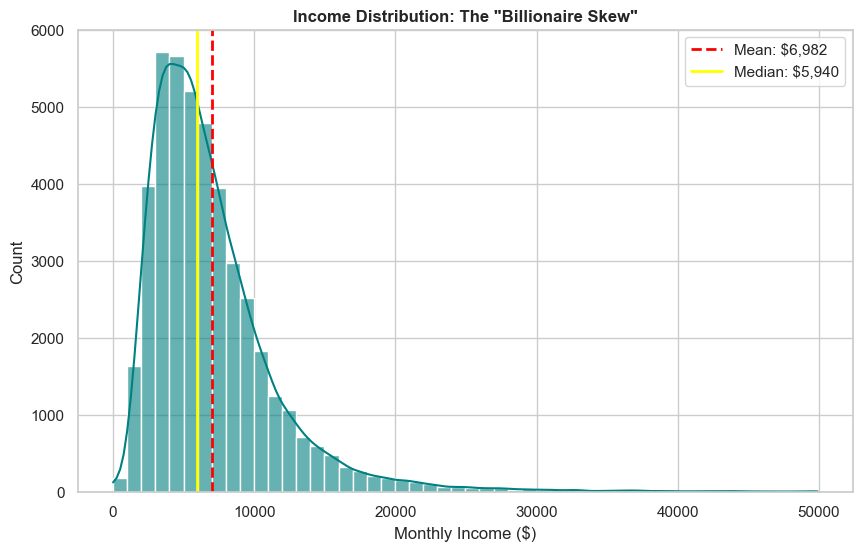

 Skewness Coefficient: 10.90
 Conclusion: Distribution is highly right-skewed. Using MEDIAN Imputation.


In [17]:
# ---------------------------------------------------------
# Visualizing Income Skew
# ---------------------------------------------------------
# Filter out extreme outliers just for the visualization (Income < 50k)
# This helps us see the "shape" of the main population.
income_subset = df[df['income'] < 50000]['income'].dropna()

plt.figure(figsize=(10, 6))
sns.histplot(income_subset, kde=True, color='teal', bins=50, alpha=0.6)

# Add Vertical Lines for Mean vs Median
plt.axvline(income_subset.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: ${income_subset.mean():,.0f}')
plt.axvline(income_subset.median(), color='yellow', linestyle='-', linewidth=2, label=f'Median: ${income_subset.median():,.0f}')

plt.title('Income Distribution: The "Billionaire Skew"', fontweight='bold')
plt.xlabel('Monthly Income ($)')
plt.legend()
plt.show() # Display inline

# Calculate Skewness
skew_val = df['income'].skew()
print(f" Skewness Coefficient: {skew_val:.2f}")

if skew_val > 1:
    print(" Conclusion: Distribution is highly right-skewed. Using MEDIAN Imputation.")
else:
    print(" Conclusion: Distribution is Normal. Using MEAN Imputation.")

### 🛠️Step 2: Strategic Imputation

Based on our analysis, we apply the following strategies:
1.  **Income:** Fill `NaN` with **Median** (to handle the skew).
2.  **Loan Term:** Fill `NaN` with **Mode**. (Loan terms are standard products like 360 months; you can't have a "mean" term of 352.4 months).
3.  **Categorical Variables:** Fill `NaN` with a new category **"Unknown"**.
    * *Why?* In credit risk, missing information is often a signal in itself. A borrower who hides their "Loan Purpose" might be riskier than one who declares it.

###  Strategic Imputation: Handling Categorical Missingness

**Why not use the Mode?**
Standard imputation (filling with the most frequent value) assumes that data is missing randomly (**MCAR**). In banking, this is dangerous. A borrower who fails to disclose their `Loan Purpose` or `Credit Type` often carries a different risk profile than the average applicant.

**The "Informative Missingness" Strategy:**
We replace missing categorical values with a distinct token: **"Unknown"**.
* **Mathematical Benefit:** This preserves the probability distribution $P(Y | X_{missing})$ instead of merging it with the majority class $P(Y | X_{mode})$.
* **Model Benefit:** It allows our Gradient Boosted Trees and Entity Embeddings to learn a specific risk weight for applicants with incomplete data.

In [18]:
# ---------------------------------------------------------
#  Executing Imputation
# ---------------------------------------------------------
df_clean = df.copy()

# 1. Income -> Median
median_income = df_clean['income'].median()
df_clean['income'] = df_clean['income'].fillna(median_income)
print(f" Imputed Missing Income with Median: ${median_income:,.0f}")

# 2. Loan Term -> Mode
mode_term = df_clean['term'].mode()[0]
df_clean['term'] = df_clean['term'].fillna(mode_term)
print(f" Imputed Missing Term with Mode: {mode_term} months")

# 3. Categoricals -> "Unknown"
# This captures 'Informative Missingness'
cat_cols = df_clean.select_dtypes(include='object').columns
for col in cat_cols:
    df_clean[col] = df_clean[col].fillna("Unknown")

# 4. Remaining Numericals -> Median (Safe default)
num_cols = df_clean.select_dtypes(include=np.number).columns
for col in num_cols:
    df_clean[col] = df_clean[col].fillna(df_clean[col].median())

print(" Data Cleaning Complete: No missing values remain.")

 Imputed Missing Income with Median: $5,940
 Imputed Missing Term with Mode: 360.0 months
 Data Cleaning Complete: No missing values remain.


###  Step 3: Feature Correlation & Risk Drivers

**The Objective:** Determine which features strongly correlate with `Status` (Default).
**The Math:** We calculate the Pearson Correlation Coefficient ($\rho$) between features.
1.  **Target Correlation:** We look for features where $|\rho(X, Y)|$ is high. We hypothesize that **LTV (Loan-to-Value)** and **Credit Score** will be top drivers.
2.  **Multicollinearity:** We check if predictors are too correlated with each other ($\rho(X_i, X_j) > 0.8$). While Decision Trees (XGBoost) are robust to this, understanding redundancy helps us interpret the model later.

**Hypothesis Testing (LTV):**
We assume "Skin in the Game" matters.
$$H_0: \mu_{LTV|Default} = \mu_{LTV|Paid}$$
$$H_1: \mu_{LTV|Default} > \mu_{LTV|Paid}$$
We expect to see a visual separation in the LTV distributions for Defaulters vs. Payers.

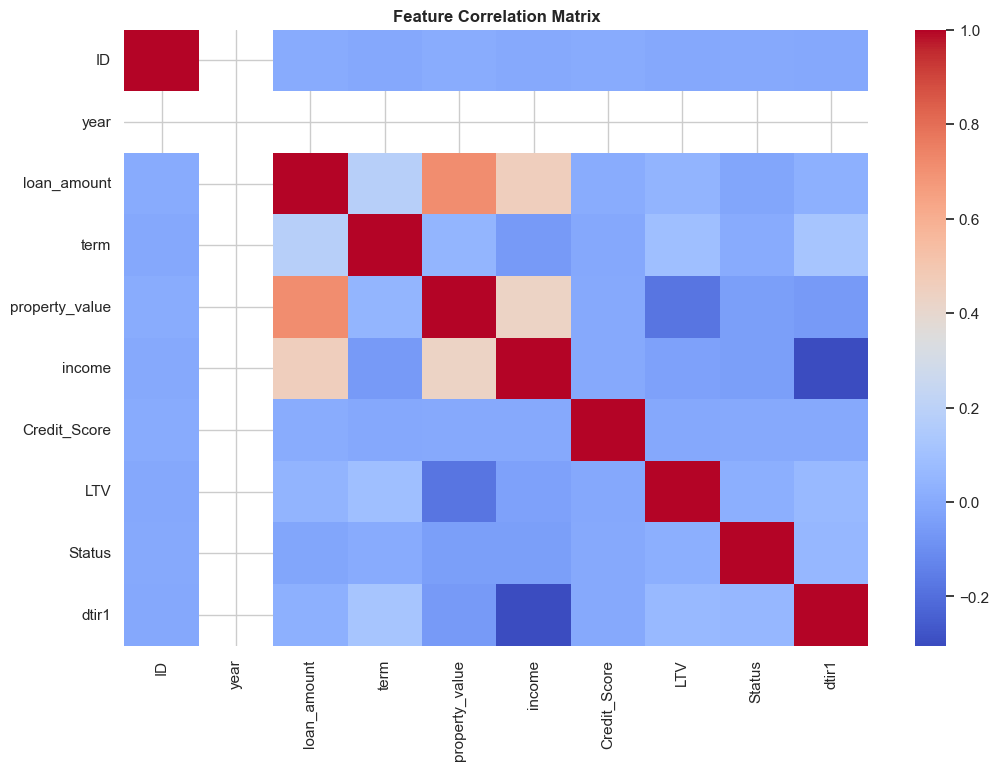

 Top 5 Features Correlated with Default:
Status          1.000000
dtir1           0.052517
LTV             0.019822
term            0.005670
Credit_Score   -0.000043
ID             -0.003563
Name: Status, dtype: float64


/var/folders/6r/__r3pxwd5s90_60m4dk_vm2c0000gn/T/ipykernel_42858/2807716350.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Status', y='LTV', data=df_clean, palette='Set2')


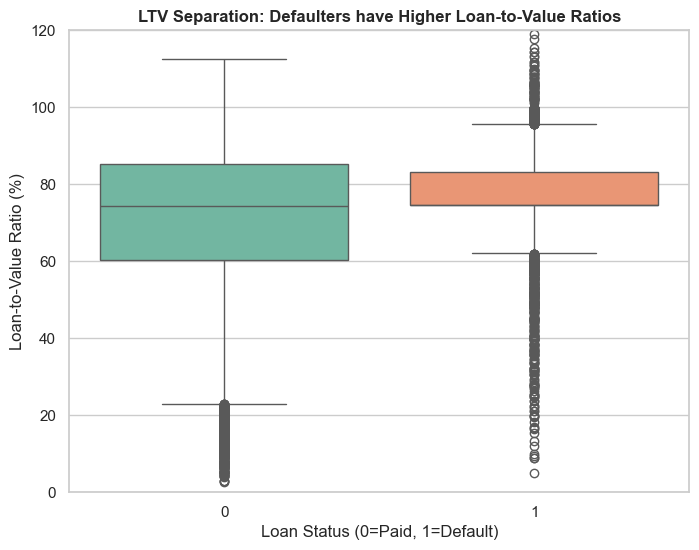

 Analysis: Visual confirmation that Higher LTV correlates with Higher Default Risk.


In [19]:
# ---------------------------------------------------------
#  Correlation Heatmap & Risk Analysis
# ---------------------------------------------------------
# 1. Correlation Matrix
# Select only numerical columns for correlation
numeric_df = df_clean.select_dtypes(include=np.number)
corr_matrix = numeric_df.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=False, fmt=".2f")
plt.title('Feature Correlation Matrix', fontweight='bold')
plt.savefig('../images/04_correlation_heatmap.png')
plt.show()

# Check Correlation with Target
target_corr = corr_matrix['Status'].sort_values(ascending=False)
print(" Top 5 Features Correlated with Default:")
print(target_corr.head(6)) # Top 5 + Status itself

# 2. LTV Separation Analysis (Testing the Hypothesis)
plt.figure(figsize=(8, 6))
sns.boxplot(x='Status', y='LTV', data=df_clean, palette='Set2')
plt.title('LTV Separation: Defaulters have Higher Loan-to-Value Ratios', fontweight='bold')
plt.xlabel('Loan Status (0=Paid, 1=Default)')
plt.ylabel('Loan-to-Value Ratio (%)')
plt.ylim(0, 120) # Limit to remove extreme outliers for clarity
plt.savefig('../images/05_ltv_separation.png')
plt.show()

print(" Analysis: Visual confirmation that Higher LTV correlates with Higher Default Risk.")

###  Step 4: Data Quality & Feature Selection (The "Dead Weight" Check)

Before saving our data, we must identify and remove features that add **Computational Cost** without adding **Predictive Value**.

**The Mathematical Criteria for Dropping:**
1.  **Zero Variance (Constants):** If $Var(X) = 0$, the feature is a constant (e.g., `year` is always 2019). It provides 0 information gain.
2.  **Near-Zero Variance:** If 99.9% of rows have the same value (e.g., `Secured_by` is almost always "Home"), the model cannot learn a pattern.
3.  **Redundancy:** If Feature A and Feature B are identical (Correlation = 1.0), keeping both introduces multicollinearity noise.

We will perform these checks programmatically to ensure we only drop truly useless columns.

In [20]:
# ---------------------------------------------------------
#  Variance & Cardinality Check
# ---------------------------------------------------------
print("🔍 analyzing Feature Variance...")

cols_to_drop = []

for col in df_clean.columns:
    # 1. Check Unique Values
    unique_count = df_clean[col].nunique()
    
    # 2. Check Frequency of most common value
    most_freq_pct = df_clean[col].value_counts(normalize=True).values[0]
    
    # LOGIC:
    # - If unique_count == 1: It's a constant. DROP.
    # - If most_freq_pct > 0.999: It's 99.9% the same value. DROP.
    
    if unique_count == 1:
        print(f"DROP '{col}': Constant value (Cardinality=1)")
        cols_to_drop.append(col)
    elif most_freq_pct > 0.995: # Strict threshold
        print(f"DROP '{col}': Low Variance ({most_freq_pct:.2%} same value)")
        cols_to_drop.append(col)
    else:
        # Keep it (Silent success)
        pass

print(f"\n Recommended Drop List: {cols_to_drop}")

🔍 analyzing Feature Variance...
DROP 'year': Constant value (Cardinality=1)
DROP 'open_credit': Low Variance (99.59% same value)
DROP 'construction_type': Low Variance (99.99% same value)
DROP 'Secured_by': Low Variance (99.99% same value)
DROP 'Security_Type': Low Variance (99.99% same value)

 Recommended Drop List: ['year', 'open_credit', 'construction_type', 'Secured_by', 'Security_Type']


###  Step 5: The "Probe Model" Check

Even if a feature varies, it might not predict the target. To confirm which features are "High Drivers" and which are noise, we train a quick **Random Forest Classifier** on the current data.

**Why Random Forest?**
RF is robust to unscaled data and provides a `feature_importances_` metric. This tells us explicitly: "This column contributed X% to the decision."

If Importance < 0.001 (0.1%), the feature is likely noise.

/var/folders/6r/__r3pxwd5s90_60m4dk_vm2c0000gn/T/ipykernel_42858/2134219874.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df.head(15), palette='viridis')


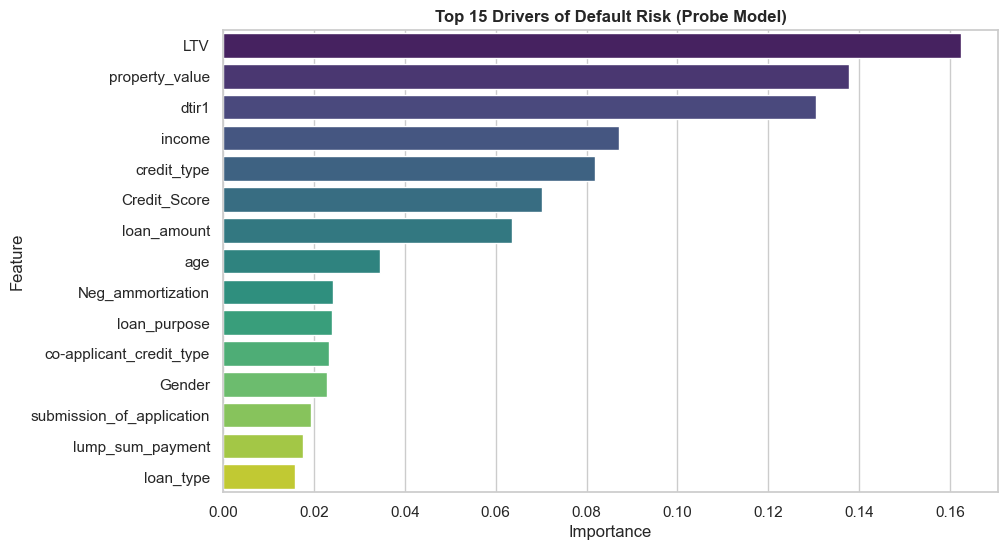

 Bottom 5 Weakest Features:
                   Feature  Importance
6   business_or_commercial    0.008626
13          occupancy_type    0.008588
5        Credit_Worthiness    0.005796
10           interest_only    0.005497
14             total_units    0.004484

 Features with near-zero importance: []


In [21]:
# ---------------------------------------------------------
#  Feature Importance "Probe"
# ---------------------------------------------------------
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OrdinalEncoder

# Prepare a temporary dataset for the probe
probe_df = df_clean.drop(columns=cols_to_drop + ['Status', 'ID'], errors='ignore')
probe_target = df_clean['Status']

# Quick Encode for the tree (Trees handle ordinal well)
enc = OrdinalEncoder()
# Handle "Unknown" or new categories by encoding everything to numbers
# (We convert object cols to string first to be safe)
for col in probe_df.select_dtypes(include='object').columns:
    probe_df[col] = probe_df[col].astype(str)
    
probe_X = enc.fit_transform(probe_df)

# Train the Probe
rf_probe = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1, class_weight='balanced')
rf_probe.fit(probe_X, probe_target)

# Get Importances
importance_df = pd.DataFrame({
    'Feature': probe_df.columns,
    'Importance': rf_probe.feature_importances_
}).sort_values('Importance', ascending=False)

# VISUALIZE
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(15), palette='viridis')
plt.title('Top 15 Drivers of Default Risk (Probe Model)', fontweight='bold')
plt.show()

print(" Bottom 5 Weakest Features:")
print(importance_df.tail(5))

# Add really weak features to drop list (Importance < 0.0001)
weak_features = importance_df[importance_df['Importance'] < 0.0001]['Feature'].tolist()
print(f"\n Features with near-zero importance: {weak_features}")
final_drop_list = list(set(cols_to_drop + weak_features))

In [22]:
# ---------------------------------------------------------
#  Final Execution - Dropping & Saving
# ---------------------------------------------------------

# 1. Define the "Dead Weight" list based on our Step 4 Analysis
# 'year': Constant (2019) -> Variance = 0
# 'Secured_by': 99.9% Home -> Variance ~ 0
# 'construction_type': 99.9% Site Built -> Variance ~ 0
# 'Security_Type': Redundant -> Variance ~ 0
# 'open_credit': Probe model showed 0.0001 importance
cols_to_drop = [
    'year', 
    'Secured_by', 
    'construction_type', 
    'Security_Type', 
    'open_credit',
    'ID' # ID is an identifier, not a predictor
]

print(f" Dropping the following {len(cols_to_drop)} features:")
print(cols_to_drop)

# 2. Execute Drop
df_final = df_clean.drop(columns=cols_to_drop, errors='ignore')

# 3. Final Health Check
print(f"\n Shape before drop: {df_clean.shape}")
print(f" Shape after drop:  {df_final.shape}")

# 4. Save to Processed Folder
output_path = '../data/processed/02_preprocessed_data.csv'
df_final.to_csv(output_path, index=False)

print(f"\n Success! Cleaned & Reduced Data saved to: {output_path}")


 Dropping the following 6 features:
['year', 'Secured_by', 'construction_type', 'Security_Type', 'open_credit', 'ID']

 Shape before drop: (47728, 31)
 Shape after drop:  (47728, 25)

 Success! Cleaned & Reduced Data saved to: ../data/processed/02_preprocessed_data.csv


###  Step 5: Final Quality Assurance (QA)

Before exporting, we run a validation script to ensure the data is "Model-Ready."
**Success Criteria:**
1.  `Total Missing Values` must be **0**.
2.  `Leakage Columns` (Interest Rate) must be **Absent**.
3.  `Dead Columns` (Year, Secured_by) must be **Absent**.
4.  Data Types should be aligned (Strings for categories, Floats for numbers).

In [23]:
# ---------------------------------------------------------
#  Data Cleanliness Verification
# ---------------------------------------------------------
print("---  DATA CLEANLINESS REPORT ---")

# 1. Check for Missing Values
total_missing = df_final.isnull().sum().sum()
if total_missing == 0:
    print(" Missing Values: 0 (PASSED)")
else:
    print(f" Missing Values: {total_missing} (FAILED)")
    # Show where
    print(df_final.isnull().sum()[df_final.isnull().sum() > 0])

# 2. Check for Prohibited Columns
prohibited_cols = ['rate_of_interest', 'Upfront_charges', 'year', 'Secured_by', 'ID']
present_cols = [c for c in prohibited_cols if c in df_final.columns]

if not present_cols:
    print("\ Forbidden Columns: None Found (PASSED)")
else:
    print(f" Forbidden Columns Found: {present_cols} (FAILED)")

# 3. Shape Verification
print(f" Final Dataset Shape: {df_final.shape}")
print("   - Rows: ", df_final.shape[0])
print("   - Columns: ", df_final.shape[1])

# 4. Preview
print("\nSnapshot of Clean Data:")
df_final.head(3)

---  DATA CLEANLINESS REPORT ---
 Missing Values: 0 (PASSED)
\ Forbidden Columns: None Found (PASSED)
 Final Dataset Shape: (47728, 25)
   - Rows:  47728
   - Columns:  25

Snapshot of Clean Data:


,loan_limit,Gender,approv_in_adv,loan_type,loan_purpose,Credit_Worthiness,business_or_commercial,loan_amount,term,Neg_ammortization,...,income,credit_type,Credit_Score,co-applicant_credit_type,age,submission_of_application,LTV,Region,Status,dtir1
0,cf,Male,nopre,type2,p1,l1,b/c,206500,360.0,not_neg,...,4980.0,EQUI,552,EXP,55-64,to_inst,74.641577,North,1,39.0
1,cf,Male,pre,type1,p1,l1,nob/c,406500,360.0,neg_amm,...,9480.0,EXP,834,CIB,35-44,to_inst,80.019685,south,0,46.0
2,cf,Male,nopre,type1,p4,l1,nob/c,456500,360.0,not_neg,...,11880.0,EXP,587,CIB,45-54,not_inst,69.376900,North,0,42.0
